# Overview

This project is part of the [IBM Data Science Certification program](https://www.coursera.org/learn/applied-data-science-capstone/home/welcome)

The commercial space age is here; several companies such as Virgin Galactic, Blue Origin, and SpaceX are making space travel affordable for everyone. Among all of them, SpaceX perhaps stands out as the most successful. One reason behind SpaceX's success is that the rocket launches are relatively inexpensive thanks to the reusability of the first stage--which is the most expensive part of a rocket launcher that carries most of the work. Therefore, if we can determine if the first stage will land, we can determine the cost of a launch. In this project, our job will be to determine the price of each launch which depends on whether the first stage would land successfully to be reused. Using machine learning models and public data on Falcon 9, we will predict if SpaceX will reuse the first stage.

### Table of Contents
* [Data Wrangling](#data-wrangling)
   * [Import Data](#data-import)
   * [Dealing with missing values](#missing-data)
* [EDA](#eda)
   * [Extract Target Variable](#eda-target)
   * [Features Selection](#fs)
       * [Discard Obsolete Variables](#fs-drop-columns)
       * [Categorical Variables](#fs-categorical)
       * [Boolean Variables](#fs-boolean)
       * [Numeric Variables](#fs-numeric)
   * [Build Features Set](#fs-build-dataset)
* [Machine Learning Predictions](#ml-predictions)
   * [Decision Tree](#ml-decision-tree)
   * [Results](#ml-results)
    

# Data Wrangling <a class="anchor"  id="data-wrangling"></a>

In [1]:
!python -m pip install pickle5

     |████████████████████████████████| 132 kB 295 kB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=245791 sha256=95cfe9a734fb4c49b6d473a859fb8eddbe884d3f9be42b2f7f2fa6984338320d
  Stored in directory: /root/.cache/pip/wheels/7e/6a/00/67136a90d6aca437d806d1d3cedf98106e840c97a3e5188198
Successfully built pickle5


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

## Import Data <a class="anchor"  id="data-import"></a>
The piece of code used to retrieve the Falcon 9 data was taken from this [notebook]('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_1_L2/jupyter-labs-spacex-data-collection-api.ipynb') which contains an API designed for this puspose and privided with the project assignment.

In [3]:
import pickle5 as pickle

with open("../input/spacex-falcon9-launch-pickle/falcon9_data.pkl", "rb") as fh:
    data = pickle.load(fh)
    falcon9_data = data
    falcon9_data.reset_index(drop=True, inplace=True)

In [4]:
falcon9_data.head(10)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1.0,False,False,False,None,1.0,0.0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1.0,False,False,False,None,1.0,0.0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1.0,False,False,False,None,1.0,0.0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1.0,False,False,False,None,1.0,0.0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1.0,False,False,False,None,1.0,0.0,B1004,-80.577366,28.561857
5,6,2014-01-06,Falcon 9,3325.0,GTO,CCSFS SLC 40,None None,1.0,False,False,False,None,1.0,0.0,B1005,-80.577366,28.561857
6,7,2014-04-18,Falcon 9,2296.0,ISS,CCSFS SLC 40,True Ocean,1.0,False,False,True,None,1.0,0.0,B1006,-80.577366,28.561857
7,8,2014-07-14,Falcon 9,1316.0,LEO,CCSFS SLC 40,True Ocean,1.0,False,False,True,None,1.0,0.0,B1007,-80.577366,28.561857
8,9,2014-08-05,Falcon 9,4535.0,GTO,CCSFS SLC 40,None None,1.0,False,False,False,None,1.0,0.0,B1008,-80.577366,28.561857
9,10,2014-09-07,Falcon 9,4428.0,GTO,CCSFS SLC 40,None None,1.0,False,False,False,None,1.0,0.0,B1011,-80.577366,28.561857


## Dealing with missing values <a class="anchor"  id="missing-data"></a>
We can see below that some of the rows are missing values in our dataset. As our dataset only contains 119 observations, we will avoid removing rows containing null data but rather fill the missing data using different techniques.

In [5]:
falcon9_data.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass       13
Orbit              1
LaunchSite         0
Outcome            0
Flights            1
GridFins           1
Reused             1
Legs               1
LandingPad        27
Block              1
ReusedCount        1
Serial             1
Longitude          0
Latitude           0
dtype: int64

We deal with the missing values in `PayloadMass` by replacing the null values with the median.

Similarily, we deal with the missing values in `Orbit`by replacing the null values with the mode.

In [6]:
# Fill missing PayloadMass with median
falcon9_data['PayloadMass'].fillna(falcon9_data['PayloadMass'].median(), inplace=True)

# Fill missing PayloadMass with median
falcon9_data['Orbit'].fillna(falcon9_data['Orbit'].mode().values[0], inplace=True)

When it comes to `Flights`, we can retrieve the number of flights a particular rocket has done by using the `Serial` variable to count the number of flights of the corresponding rocket has made after the current observed `Date`. If there were no other flights of a rocket with the same serial number after the current observed date then `Flights` will be set to `1`.

In [7]:
# Fill missing Flights
falcon9_data.loc[falcon9_data['Flights'].isnull(), 'Flights'] = falcon9_data[falcon9_data['Flights'].isnull()]\
    .apply(lambda x: 1 + falcon9_data.loc[(falcon9_data['Serial'] == x['Serial']) & (falcon9_data['Date'] > x['Date'])].shape[0], axis=1)

Certain variables such as `GridFins`, `Reused`, and `Legs` are of type boolean. We can then assume the missing values to be `False`. Similarily, we can assume the missing values in `ReusedCount` to be `0` when the corresponding `Reused` variable is set to `False` or also missing.

In [8]:
# Fill missing GridFins, Reused, and Legs with False
falcon9_data['GridFins'].fillna(False, inplace=True)
falcon9_data['Reused'].fillna(False, inplace=True)
falcon9_data['Legs'].fillna(False, inplace=True)

# Fill missing ReusedCount with 0
falcon9_data['ReusedCount'].fillna(0, inplace=True)
falcon9_data['Block'].fillna(0, inplace=True)

At last, `Serial` contains the serial number of the rockets. If the `Serial` is not provided, we could set its missing values to `unknown`.

In [9]:
# Fill missing Serial with 'unknown'
falcon9_data['Serial'].fillna('Unknown', inplace=True)

At this point, only `LandingPad` contains missing values. However, the fact the missing values of this particular variable are meaningful as they imply there was not landing pad used during the launch.

Before starting our EDA, we rename the values of the column `LandingPad` to make them more readable. We also replace the missing values with `NoLandingPad`.

In [10]:
padno = 0
for padid in falcon9_data["LandingPad"].unique():
    if padid is not None:
        falcon9_data["LandingPad"].replace(padid, f"LandingPad_{padno}", inplace=True)
    else:
        falcon9_data["LandingPad"].fillna("NoLandingPad", inplace=True)
    padno += 1

del padno

## Fixing data types
We make sure each feature has the right data type

In [11]:
falcon9_data["Date"] = pd.to_datetime(falcon9_data["Date"])
falcon9_data["Flights"] = falcon9_data["Flights"].astype(int)
falcon9_data["GridFins"] = falcon9_data["GridFins"].astype(bool)
falcon9_data["Reused"] = falcon9_data["Reused"].astype(bool)
falcon9_data["Legs"] = falcon9_data["Legs"].astype(bool)
falcon9_data["Block"] = falcon9_data["Block"].astype(int)
falcon9_data["ReusedCount"] = falcon9_data["ReusedCount"].astype(int)

## Save cleaned data
At this stage, our data is clean. The numeric values (including `Date`) appears to be in the proper range and looking at the unique values of the categorical values, we did not identify any typos.

We can then safely save the cleaned dataset to the disk.

In [12]:
# falcon9_data.to_pickle("falcon9_data_clean_v1.pkl")

# Exploratory Data Analysis & Features Selection <a class="anchor"  id="eda"></a>

In [13]:
# Make a copy
df = falcon9_data.copy()

In [14]:
df.dtypes

FlightNumber               int64
Date              datetime64[ns]
BoosterVersion            object
PayloadMass              float64
Orbit                     object
LaunchSite                object
Outcome                   object
Flights                    int64
GridFins                    bool
Reused                      bool
Legs                        bool
LandingPad                object
Block                      int64
ReusedCount                int64
Serial                    object
Longitude                float64
Latitude                 float64
dtype: object

## Process Target Variable <a class="anchor"  id="eda-target"></a>

The variable `Outcome` is composed of two parts. First, we have a boolean value (True or False) or 'None' that indicates if the launch was successful or not. The second part indicates where the first stage landed. For example `True Ocean` means the mission outcome was successfully  landed to a specific region of the ocean while <code>False Ocean</code> means the mission outcome was unsuccessfully landed to a specific region of the ocean. `None ASDS` and `None None` these represent a failure to land.

We can then split `Outcome` into two columns `LandingOutcome` and `landingRegion`. We will be using the `landingOutcome` column as our target.

In [15]:
df[["LandingOutcome", "LandingRegion"]] = df["Outcome"].str.split(" ", 1, expand=True)

# We fill the null values in LandingPlace by 'Failed' signaling that the launch was a failure.
# df["LandingRegion"].replace("None", "Failed", inplace=True)

# Replace null values by False in LandingOutcome
df["LandingOutcome"].replace('None', 0, inplace=True)
df["LandingOutcome"].replace('False', 0, inplace=True)
df["LandingOutcome"].replace('True', 1, inplace=True)

# While were are at it, we can set the successful launch to 1 and the unsuccessful to 0 from the boolean values
df = df.astype({"LandingOutcome": int})

In [16]:
# Drop old Outcome column
df.drop(columns=["Outcome"], axis=1, inplace=True)

In [17]:
round(100 * df["LandingOutcome"].value_counts() / df.shape[0], 2)

1    73.11
0    26.89
Name: LandingOutcome, dtype: float64

Our two classes `0` (Failure) and `1` (Success) are considerably imbalanced. Out of every rocket launch in the dataset, 73.11% were successful whereas 26.89% were unsuccsessful.

## Features Selection <a class="anchor"  id="fs"></a>

### Helper functions

In [18]:
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr

In [19]:
# Apply Chi Squared test then plot the p-values on a heatmap
def plot_chisquare_heatmap(df, target, column_names, figsize=(8,6)):
    column_names.append(target)
    n_cols = len(column_names)
    chisq_df = pd.DataFrame(np.zeros((n_cols,n_cols)), columns=column_names, index=column_names)
    i = 0
    j = 0
    
    for icol in column_names:
        for jcol in column_names:
            # Build contigency table
            contigency_tab = pd.crosstab(df[icol], df[jcol])
            
            # Get p-value and other stats
            c, p, dof, expected = chi2_contingency(contigency_tab)
            
            # We round very low p-values to 0 and add the p-values to the chisq_matrix
            chisq_df.iloc[i,j] = round(p, 5)
            
            # A condition to use Chi Square is that the expected frequencies should be at 
            # least 5 for the majority (80%) of the cells
            
            # Get % of cells with frequency of at least 5
            expected_percent = 100 * expected[expected >= 5].size / expected.size
            
            #if icol == jcol:
            #    chisq_df.iloc[i,j] = 0.0
            
            # If the expected frequency is less than 5 for the (20%), we ignore the p-value
            # between the two variables. We will then keep the two variables.
            # We set the p-value to 2 in order to better visualize this case
            if expected_percent < 20:
                chisq_df.iloc[i,j] = 2
            else:
                chisq_df.iloc[i,j] = round(p, 5)
            
            j += 1
            
        i += 1
        j = 0
    
    _, ax = plt.subplots(figsize=figsize)
    sns.heatmap(chisq_df, annot=True, ax=ax)
    #ax.set_xticklabels(labels=cols, rotation=90)
    #ax.set_yticklabels(labels=cols, rotation=0)
    ax.set_title("Chi Squared p-values", fontsize=14)
    plt.show()


In [20]:
# Compute the correlation between variables and the statistical significance of that correlation
# then plot the correlation coefficient and p-values on a heatmap
def plot_corr_pvalue(df, column_names, figsize=(11, 4)):
    ncols = len(column_names)
    corr_matrix = pd.DataFrame(np.zeros((ncols, ncols)), columns=column_names, index=column_names)
    pvalue_matrix = pd.DataFrame(np.zeros((ncols, ncols)), columns=column_names, index=column_names)
    i = 0
    j = 0
    
    for icol in column_names:
        for jcol in column_names:
            # Compute correlation coefficient and p-value
            corr, p = pearsonr(df[icol], df[jcol])
            
            corr_matrix.iloc[i,j] = round(corr, 5)
            
            # We round very low p-values to 0
            pvalue_matrix.iloc[i,j] = round(p, 5)
            j += 1
            
        j = 0
        i += 1
    
    _, ax = plt.subplots(figsize=figsize, ncols=2, nrows=1)
    # Plot correlation matrix
    sns.heatmap(corr_matrix, annot=True, ax=ax[0])
    ax[0].set_title("Correlation Matrix", fontsize=14)
    ax[0].set_xticklabels(column_names, rotation=90)
    ax[0].set_yticklabels(column_names, rotation=0)
    
    # Plot p-values matrix
    sns.heatmap(pvalue_matrix, annot=True, ax=ax[1])
    ax[1].set_title("p-values Matrix", fontsize=14)
    ax[1].set_xticklabels(column_names, rotation=90)
    ax[1].set_yticklabels(column_names, rotation=0)
    plt.show()


In [21]:
def plot_barchart(df, columns, figsize=(18, 4)):
    ncols = len(columns)
    _, axes = plt.subplots(figsize=figsize, ncols=ncols, nrows=1)
    for i in range(len(columns)):
        axes[i].set_title(f"Landing Success Rate", fontsize=14)
        sns.barplot(x=df.groupby(columns[i]).apply(lambda x: str(x.name)),
                    y="LandingOutcome",
                    data=round(100 * df.groupby(columns[i]).mean(), 2), ax=axes[i])
        axes[i].set_xlabel(columns[i])
        axes[i].set_ylabel("Success Rate (%)")
        
        if columns[i] == "LandingPad":
            axes[i].set_xticklabels(axes[i].xaxis.get_ticklabels(), rotation=90)
        
    plt.show()

In [22]:
def plot_kde(df, column_names, target, ncols=2):
    nrows = int(np.ceil(len(column_names) / ncols))
    _, ax = plt.subplots(figsize=(5.5 * ncols * 1.1, 3 * nrows * 1.3), ncols=ncols, nrows=nrows)
    for i in range(len(column_names)):
        sns.kdeplot(data=df, x=column_names[i], hue=target, alpha=0.9, ax=ax[i//ncols][i%ncols])
    plt.show()

### Create New Variables and Drop Obsolete/Redundant Variables <a class="anchor"  id="fs-drop-columns"></a>
Some of the variables of our datasets are redundant or not useful. First, `FlightNumber` is used as an ID for each of the flights. Therefore, it does not hold much values for our classification problem. Similarily, `BoosterVersion` only has one single possible values (Falcon 9). At last, `Longitude` and `Latitude` are coordonates of each `LauchSite`. The pair of geo coordinates could be substituted by the corresponding `LaunchSite`.

From the `Date` column, we can extract the `Year`.

In [23]:
df["Year"] = df["Date"].dt.year

In [24]:
df.drop(columns=["Date", "FlightNumber", "BoosterVersion", "Longitude", "Latitude"], inplace=True)

### Categorical Variables <a class="anchor"  id="fs-categorical"></a>

We start with the categorical features. As we are dealing with a classification problem with multiple categorical features, it appropriate to use the Chi Square method for feature selection. 

We use the function `plot_chisquare_heatmap` to produce a heatmap of p-values obtain by applying Chi Square on our categorical features and target. A p-value lower than 0.05 in this case indicate that there exists a relationship between two variables. Otherwise, the two variables are considered independent.

One of the condition to use Chi Squared is that the expected frequencies should be at least 5 for the majority (80%) of the cells. When this condition is not satisfied, `plot_chisquare_heatmap` sets the p-value to `2` thus indicating that the two variables could be used.

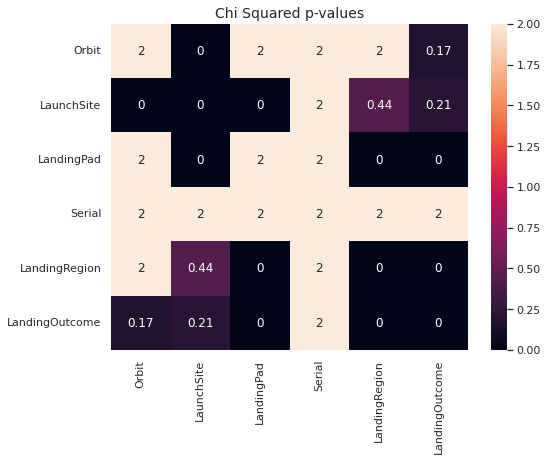

In [25]:
# Group categorical features in a list
categorical_cols = ["Orbit", "LaunchSite", "LandingPad", "Serial", "LandingRegion"]

# Plot heatmap of p-values
plot_chisquare_heatmap(df, column_names=categorical_cols, target="LandingOutcome")

From the above heatmap we see that `Serial` do not satisfy the condition of a Chi Square test. Moreover, `Serial` is a used to uniquely identify a given rocket. As our goal is to predict the success of any rocket launch based on certain features, this information could be irrelevant. We can then remove those three columns from our features set.

Next, `Orbit` and `LaunchSite` have a p-value of 0.17 and 0.21 respectively when evaluated against the target. These two variables are also not independent from each other as shown in the Chi Squared p-values table.

`LauchSite` also has a relationship with `LandingPad`. As the later has a stronger relationship with the target variable, we can drop `LaunchSite` from our features set.

There appears to be a strong relationship between `LandingPad` and `LandingRegion`. As the two variables are not independent, we could drop one of them. 

Let's visualize how the launches success rate varies with different values of `LandingPad`, `LandingRegion`, and `Orbit`.

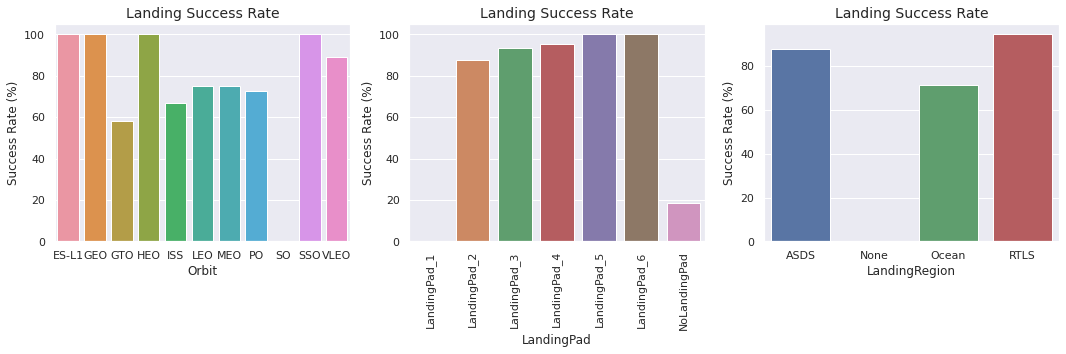

In [26]:
plot_barchart(df, columns=["Orbit", "LandingPad", "LandingRegion"])

The bar charts above show some variations in the success rate of rocket landings with different variables. 

The lauches have a higher success rate when launched in certain `Orbit` than others. For example, ES-L1, GEO, HEO, and SSO have a 100% success rate while SO is at 0%.

Similarily to `Orbit`, the different `LandingRegion` also lead to different success rates. RTLS has the highest success rate while landing on the Ocean is less efficient.

On the other hand, there does  not appears to be much difference in the success rate of different `LandingPad`. Beside using `LandingPad_1` and no landing pad, all the other possibilities lead to similar success rates.

In [27]:
pd.crosstab(df["LandingPad"], df["LandingRegion"])

LandingRegion,ASDS,None,Ocean,RTLS
LandingPad,,,,
LandingPad_1,2,0,0,0
LandingPad_2,49,0,0,0
LandingPad_3,0,0,0,15
LandingPad_4,22,0,0,0
LandingPad_5,0,0,0,3
LandingPad_6,1,0,0,0
NoLandingPad,0,20,7,0


As noted earlier in the Chi Squared p-values matrix, there seem to be a strong relationship between `LandingPad` and `LandingRegion`. The contigency table above shows that each landing pad is associated with only one single `LandingRegion`. Not using a landing pas (NoLandingPad) either lead to a failure to launch or a landing on the ocean. Considering this information additional information, we can discard `LandingPad` from the features set and only consider `LandingRegion`.

In [28]:
df.drop(columns=["Serial", "LaunchSite", "LandingPad"], inplace=True)

### Boolean Variables <a class="anchor"  id="fs-boolean"></a>
We have in total 3 variables of type Boolean: `GridFins`, `Reused`, and `Legs`. We can visualize the relationship between these variables and the target using a bar chart.

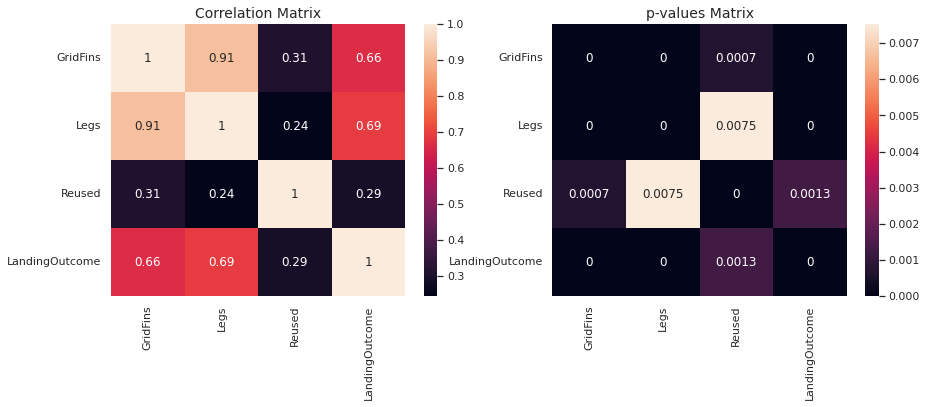

In [29]:
boolean_cols = ["GridFins", "Legs", "Reused"]
# Plot correlation and p-values matrices
plot_corr_pvalue(df, boolean_cols + ["LandingOutcome"], figsize=(14.5, 5))

Here, we can observe that all three of our boolean variables have a relationship with `LandingOutcome`. We use a correlation matrix have a better sense on the strengh of the relationships.

The correlation matrix above shows that the variables `GridFins` and `Legs` are highly correlated (91%). As `Legs` shows the largest difference in the success rate and strongest correlation to `LandingOutcome`, we will ignore `GridFins`.

In [30]:
df.drop(columns=["GridFins"], inplace=True)

The variable `Reused` has a weak correlation with the target. However, we can notice that `Reused` and `ReusedCount` are linked. As `ReusedCount` provides more information--and not just `True` or `False`--it could be a stronger feature. 

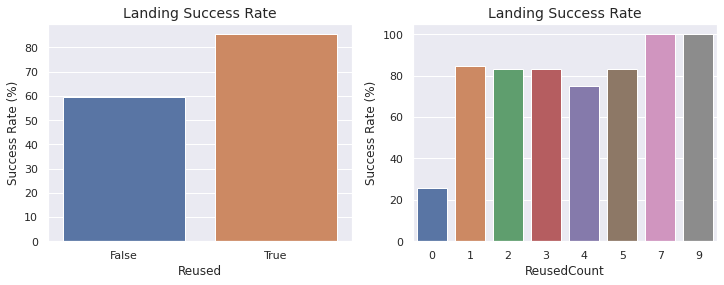

In [31]:
plot_barchart(df, columns=["Reused", "ReusedCount"], figsize=(12, 4))

The bar plot above shows the success rate of the first stage landing based on how many time it has been reused. The difference in the success rate does not appear to be significant especially when we consider that when a rocket fail launch or land, it it destroyed. The first stage is only reusable until it is destroy. Our goal is to predict if the outcome of le landing will be positive thus indicating that the first stage could be reused in the futur. Therefore, we can drop both `Reused` and `ReusedCount` from the features set.

In [32]:
df.drop(columns=["Reused", "ReusedCount"], inplace=True)

### Numeric Variables <a class="anchor"  id="fs-numeric"></a>
We are left with 4 numeric variables to consider: `PayloadMass`, `Flights`, `Block`, and `ReusedCount`.

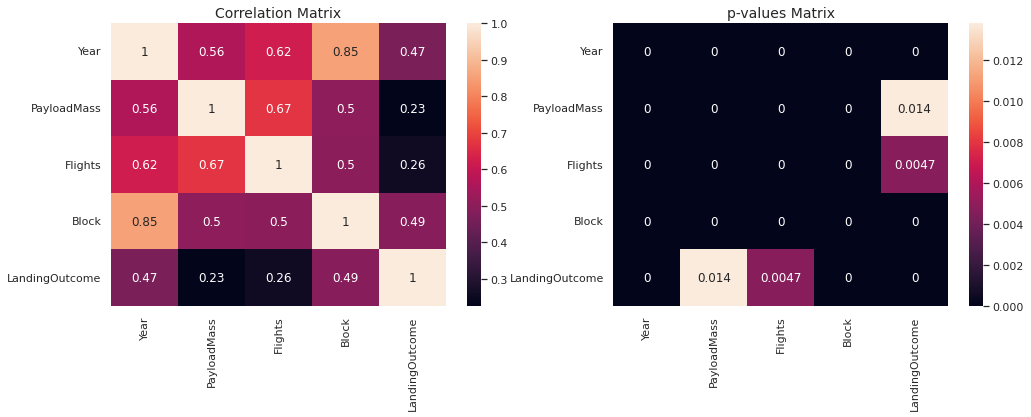

In [33]:
numeric_cols = ["Year", "PayloadMass", "Flights", "Block"]
# Plot correlation and p-values matrices
plot_corr_pvalue(df, numeric_cols + ["LandingOutcome"], figsize=(16.5, 5.2))

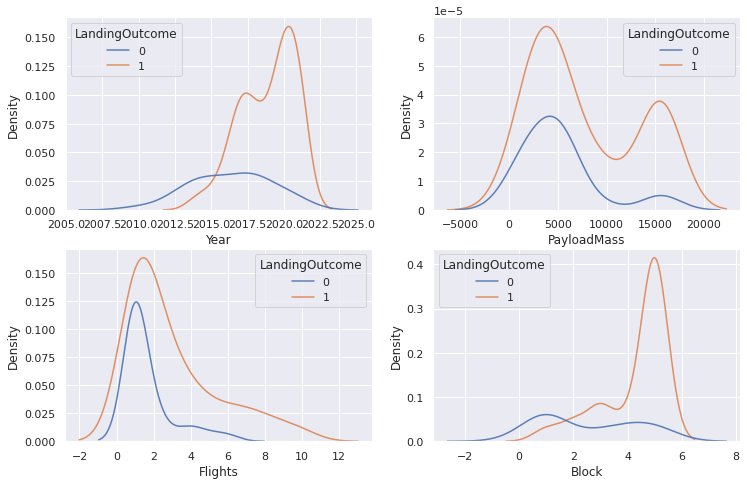

In [34]:
plot_kde(df, numeric_cols, target="LandingOutcome", ncols=2)

`Year` and `Block` are correlated to each other with a coefficient of 0.85. This suggests a colinearity between the two variables, thus we should drop one.

Looking at the density plot above, we can see that the success rate of the first stage landings grows by the years. However, the year alone as a value would not have much impact on the success rate. We can assume that the higher success rate in the most recent years is due not by the year itself but rather some newer techniques or features added to the rockets and/or landing procedures. For this reason, `Block` would be a better feature to use in our classification problem.

`PayloadMass` and `Flights` have the lowest correlation coefficients thus suggesting that they do not have a considerable influence on the `LandingOutcome`. The associated density plots also support this observation. We could remove these two `PayloadMass` and `Flights` from the features set.

#### Group PayloadMass

Based on the informations found on [Wikipedia](https://en.wikipedia.org/wiki/Small-lift_launch_vehicle#See_also), we can group the `PayloadMass` into four groups: Small-Lift (less than 2,000), Medium-Lift (2,000-20,000), Heavy-Lift (20,000-50,000), and Super-Lift (over 50,000).

In [35]:
def group_payloadmass(df):
    df.loc[df["PayloadMass"] < 2000, "PayloadMass"] = 0
    df.loc[(2000 <= df["PayloadMass"]) & (df["PayloadMass"] < 20000), "PayloadMass"] = 1
    df.loc[(20000 <= df["PayloadMass"]) & (df["PayloadMass"] < 50000), "PayloadMass"] = 2
    df.loc[df["PayloadMass"] > 50000, "PayloadMass"] = 2
    df["PayloadMass"].replace({0: "Light", 1: "Medium", 2: "Heavy", 3: "Super-Heavy"}, inplace=True)

PayloadMass
Light     61.54
Medium    74.53
Name: LandingOutcome, dtype: float64



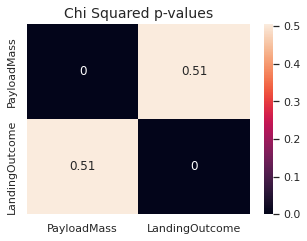

In [36]:
# Group payload mass
group_payloadmass(df)

# Print success rate per payload group
print(round(100 * df.groupby("PayloadMass").mean()["LandingOutcome"], 2))
print()

# Show Chi Square p-value matrix against target variable
plot_chisquare_heatmap(df, column_names=["PayloadMass"], target="LandingOutcome", figsize=(5,3.5))

Even after grouping its values into different categories,`PayloadMass` is still independent from `LandingOutcome`.

In [37]:
df.drop(columns=["PayloadMass", "Flights", "Year"], inplace=True)

## Build Features Set <a class="anchor"  id="fs-build-dataset"></a>
At this stage, we are left with 5 variables in our features set. Each of these variables are statistically independent to each other and have a tangible relationship with the target.

In [38]:
df.columns

Index(['Orbit', 'Legs', 'Block', 'LandingOutcome', 'LandingRegion'], dtype='object')

In [39]:
def get_onehot(df, column):
    # Apply one-hot encoding
    df = df.join(pd.get_dummies(df[column], prefix=column))
    # Drop old variable
    return df.drop(columns=column)

We now proceed at transforming this dataset into a appropriate feature set. First we transform the boolean variables to they contains 0 and 1 instead of True and False

In [40]:
df = df.astype({"Legs": int})

Considering that most machine learning algorithms require numeric values, we proceed to transforming our categorical features using a one-hot encoding.

In [41]:
df = get_onehot(df, column=["Orbit"])
df = get_onehot(df, column=["LandingRegion"])

In [42]:
df.head()

,Legs,Block,LandingOutcome,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LandingRegion_ASDS,LandingRegion_None,LandingRegion_Ocean,LandingRegion_RTLS
0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


Our features sets are now ready to be fed to a machine learning model

# Machine Learning Predictions <a class="anchor"  id="ml-predictions"></a>

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [44]:
def plot_confusion_matrix(y=None,y_predict=None, cm=None):
    if y is not None and y_predict is not None:
        cm = confusion_matrix(y, y_predict, normalize='all')
    elif cm is None:
        raise Exception("Either confusion matrix or y and y_hat required")
    
    _, ax = plt.subplots(figsize=(4.5,3.5))
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix', fontsize=14); 
    ax.xaxis.set_ticklabels(['did not land', 'land']);
    ax.yaxis.set_ticklabels(['did not land', 'landed'])

In [45]:
# Concatenate features and target sets
data = np.column_stack((
    df[[c for c in df.columns if c != "LandingOutcome"]].values, 
    df["LandingOutcome"].values
))

In [46]:
# Split dataset into train and test sets
# X_train, X_test, Y_train, Y_test = train_test_split(data[:, :-1], data[:,-1], test_size=0.2, shuffle=True, random_state=42)

## Decision Tree <a class="anchor"  id="ml-decision-tree"></a>
As noted earlier, the classes in our data are imbalanced. There are much more successful rocker launches than failures. Decision trees usually perform well on imbalanced data as the splitting rules can force both classes to be addressed.

In [47]:
from sklearn.tree import DecisionTreeClassifier

In [48]:
parameters = {
     'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1,2,4],
     'min_samples_split': [2,3,4,10],
     'class_weight': ['balanced', None]
}

In [49]:
tree_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=parameters, scoring="accuracy", cv=6)
tree_cv.fit(data[:, :-1], data[:, -1])
tree_cv.best_score_

0.9153508771929825

In [50]:
tree_cv.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'splitter': 'best'}

Because we are dealing with a very small dataset that is also imbalanced, it would be a good idea to evaluate our models using a stratified cross validation.

In [51]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [52]:
n_splits = 10
n_repeats = 2
# Matrix of scores: accuracy, precision, recall, and f1
scores = np.zeros((n_splits * n_repeats, 4))
# Combines the confusion matrices of each fold
confusion_matrices = np.zeros((n_splits * n_repeats, 4))

skfold = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
i = 0
for train_idx, test_idx in skfold.split(data[:,:-1], data[:,-1]):
    X_train, Y_train = data[train_idx, :-1], data[train_idx, -1]
    X_test, Y_test = data[test_idx, :-1], data[test_idx, -1]
    
    # Train model
    model = DecisionTreeClassifier(
        class_weight=None,
        criterion="gini",
        max_depth=6,
        max_features="auto",
        min_samples_leaf=2,
        min_samples_split=10,
        splitter="best",
        random_state=42
    )
    
    model.fit(X_train, Y_train)
    
    # Evaluate predictions
    predictions = model.predict(X_test)
    
    # Record evaluation scores
    scores[i][0] = accuracy_score(predictions, Y_test)
    scores[i][1] = precision_score(predictions, Y_test)
    scores[i][2] = recall_score(predictions, Y_test)
    scores[i][3] = f1_score(predictions, Y_test)
    
    # Build a confusion matrix for each bootstrap iteration
    cm = confusion_matrix(predictions, Y_test, normalize="true")
    confusion_matrices[i][0] = cm[0][0]
    confusion_matrices[i][1] = cm[0][1]
    confusion_matrices[i][2] = cm[1][0]
    confusion_matrices[i][3] = cm[1][1]
    
    i += 1

scores = np.mean(scores, axis=0)
print("accuracy: %.2f precision: %.2f recall: %.2f f1: %.2f" % (scores[0], scores[1], scores[2], scores[3]))

accuracy: 0.91 precision: 0.99 recall: 0.90 f1: 0.94


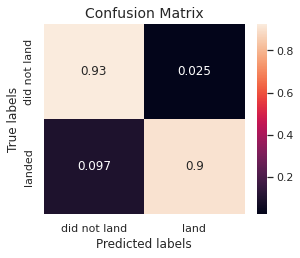

In [53]:
confusion_matrices = np.mean(confusion_matrices, axis=0)
cm = np.reshape(confusion_matrices, (-1, 2))
plot_confusion_matrix(cm=cm)

# Results <a class="anchor"  id="ml-results"></a>

Our decision tree model is able to reach satisfying performances. We obtain an accuracy of 91%, a precision of 99% and recall of 90%. The F1-score is at 94%. 

Based on the above confusion matrix, our model is slightly better at predicting if the first stage will land successfully.